## Causal analysis of COVID-19 transmission in the United States

In [1]:
%matplotlib inline
import os
import requests
import urllib 

import pandas as pd
import numpy as np
import statsmodels.api as sm
import pymc3 as pm
import scipy

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import linear_model
from scipy import stats as sps
from sklearn.feature_selection import SelectFromModel
from IPython.display import display
from scipy.stats import gamma
from scipy.stats import invgamma
from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import halfnorm
import random
import math

## 1. Data preprocessing

### 1.1 Import covariates and outcome data

In [271]:
covid_cases = pd.read_csv('/Users/likehang/Desktop/Thesis/data/covid_19_t.csv')
icu = pd.read_csv('/Users/likehang/Desktop/Thesis/data/icu_bed.csv')
mask = pd.read_csv('/Users/likehang/Desktop/Thesis/data/mask_use.csv')
trip_distance = pd.read_csv('/Users/likehang/Desktop/Trips_by_Distance.csv')
mobility = pd.read_csv('/Users/likehang/Desktop/Thesis/data/2020_US_Region_Mobility_Report.csv')
age_group = pd.read_excel("/Users/likehang/Desktop/Thesis/data/age_group.xlsx")

### 1. 2 Preprocessing for behavioral variables

#### 1.2.1 Trips in distances

In [272]:
trip_distance['Level'] = trip_distance['Level'].astype('str')
trip_distance_1 = trip_distance['Level'] == 'County'
trip_distance = trip_distance.loc[trip_distance_1]
trip_distance = trip_distance[(trip_distance['Date'] > '2020/01/18') & (trip_distance['Date'] < '2020/08/21')]

In [273]:
trip_distance["Number of Trips 1-10"] = trip_distance.loc[:,["Number of Trips <1","Number of Trips 1-3","Number of Trips 3-5","Number of Trips 5-10"]].sum(axis=1)
    
trip_distance["Number of Trips 10-100"] = trip_distance.loc[:,["Number of Trips 10-25","Number of Trips 25-50", "Number of Trips 50-100"]].sum(axis=1)

trip_distance["Number of Trips >100"] = trip_distance.loc[:,["Number of Trips 100-250","Number of Trips 250-500", "Number of Trips >=500"]].sum(axis=1)

trip_distance.drop(trip_distance.columns.difference(['Date','State FIPS','Population Not Staying at Home', 'Number of Trips 1-10','Number of Trips 10-100','Number of Trips >100']), 1, inplace=True)

In [274]:
trips = trip_distance.groupby(['Date', 'State FIPS']).agg({ 'Number of Trips 1-10':'sum',
                                                    'Number of Trips 10-100':'sum',
                                                    'Number of Trips >100':'sum',
                                                    'Population Not Staying at Home':'sum'})

trips = pd.DataFrame(trips).reset_index()

trips.to_csv("/Users/likehang/Desktop/trips_distance_cleaned.csv")

#### 1.2.2 Mask use 

In [275]:
mask['COUNTYFP'] = mask['COUNTYFP'].astype(str)
mask['COUNTYFP'] = mask['COUNTYFP'].apply(lambda x: x.zfill(5))
mask['State'] = mask.COUNTYFP.astype(str).str[:2]

In [276]:
mask = mask.groupby('State').mean().reset_index()
mask.to_csv("/Users/likehang/Desktop/mask_use_cleaned.csv")

#### 1.2.3 Mobility report

In [277]:
mobility = mobility[mobility.iso_3166_2_code.notnull()]
mobility.drop(['country_region_code', 'country_region','sub_region_2','metro_area','census_fips_code'], axis=1, inplace=True)
mobility = mobility[(mobility['date'] > '2020-01-18') & (mobility['date'] < '2020-08-21')]
mobility.to_csv("/Users/likehang/Desktop/mobility_cleaned.csv")

### 1.3 Preprocessing for demographics variables

#### 1.3.1 ICU beds number

In [278]:
icu = icu.groupby('State',as_index=False).agg({'ICU_beds':'mean'}).rename({'ICU_beds':'ICU_beds'},axis=1)
icu.to_csv("/Users/likehang/Desktop/icu_beds_cleaned.csv")

#### 1.3.2 Age groups

In [279]:
age_group['n_1'] = age_group.loc[:,["0_9","10_19","20_29","30_39","40_49","50_59","60_69","70_79","80_100"]].sum(axis=1)

age_group['n_2'] = age_group.loc[:,["60_69","70_79","80_100"]].sum(axis=1)

age_group['prop over 60'] = age_group['n_2'] / age_group['n_1']

In [280]:
age_group.to_csv("/Users/likehang/Desktop/age_group_cleaned.csv")

#### 1.3.3 Policy response index

In [281]:
policy = pd.read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv").reset_index()

/Users/likehang/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [282]:
policy = pd.DataFrame(policy)
policy['CountryName'] = policy['CountryName'].str.strip()
policy = policy.loc[policy['CountryName'] == 'United States']

In [283]:
policy = policy[policy.RegionName.notnull()]
policy = policy[(policy['Date'] > 20200118) & (policy['Date'] < 20200821)]
policy.to_csv("/Users/likehang/Desktop/policy_index_cleaned.csv")

In [284]:
policy.to_csv("/Users/likehang/Desktop/policy_index_cleaned.csv")

### 1.4 Python crawler to extract COVID 19 Google trends data

In [12]:
import crawler_google as crawler
from pytrends.request import TrendReq

In [288]:
google_data = crawler.google('Covid',100)
for keyword in ['Coronavirus', 'Hand Sanitizer', 'Lockdown', 'Masker', 'disinfecting', 'takeout', 'movie ticket', 'restaurant', 'dining out', 'food delivery','flight','train', 'uber', 'stay at home','work from home', 'Pandemic','Social Distancing', 'Vaccine', 'Zoom', 'home schooling','clorox','quarantine','grocery']:
    data2 = crawler.google(keyword,100)
    google_data = google_data.merge(data2) 

In [289]:
google_data.to_csv("/Users/likehang/Desktop/google_trend_cleaned.csv")

In [290]:
google_data.head()

,time,Covid,Coronavirus,Hand Sanitizer,Lockdown,Masker,disinfecting,takeout,movie ticket,restaurant,...,stay at home,work from home,Pandemic,Social Distancing,Vaccine,Zoom,home schooling,clorox,quarantine,grocery
0,2020/01/18,0,0,1,0,17,2,14,90,78,...,1,16,0,0,9,5,6,3,0,37
1,2020/01/19,0,1,1,0,14,2,11,63,64,...,1,19,0,0,10,6,15,5,1,38
2,2020/01/20,0,2,1,0,16,2,10,49,60,...,1,21,1,0,11,6,10,5,1,24
3,2020/01/21,0,4,1,1,15,2,13,47,62,...,1,19,1,0,12,6,6,7,1,27
4,2020/01/22,0,5,1,1,16,2,14,54,64,...,1,19,2,0,12,6,12,6,2,25


In [2]:
def get_searches(state):
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload(['covid'], cat=0, timeframe='2020-02-15 2020-08-16',  gprop='', geo=state)
    df = pytrends.interest_over_time()
    df = df.reset_index()
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    
    for key_word in ['coronavirus', 'sanitizer', 'lockdown', 'face mask', 'disinfecting wipes', 'takeout', 'movie ticket', 'restaurant', 'dining out', 'food delivery','flight','train', 'uber', 'stay at home','work from home', 'Pandemic','Social Distancing', 'Vaccine', 'Zoom', 'home schooling','clorox','quarantine','grocery','covid test','outdoor','covid symptoms']:
        pytrends = TrendReq(hl='en-US', tz=360)
        pytrends.build_payload([key_word], cat=0, timeframe='2020-02-15 2020-08-16',  gprop='',geo=state) 
        df1 = pytrends.interest_over_time()
        df1 = df1.reset_index()
        df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m-%d')
        df = df.merge(df1, on=['date', 'isPartial'], how = 'left')
    df = df.rename({"date": "Date"},axis=1)
    return df

In [7]:
data_AZ = get_searches('US-AZ')

### 1.5 Preview and reshape the covariates datasets

In [48]:
covid_cases = pd.read_csv('/Users/likehang/Desktop/Thesis/data/covid_19_t.csv')
icu = pd.read_csv('/Users/likehang/Desktop/data cleaned/icu_beds_cleaned.csv')
mask = pd.read_csv('/Users/likehang/Desktop/data cleaned/mask_use_cleaned.csv')
trip_distance = pd.read_csv('/Users/likehang/Desktop/data cleaned/trips_distance_cleaned.csv')
mobility = pd.read_csv('/Users/likehang/Desktop/data cleaned/mobility_cleaned.csv')
age_group = pd.read_csv("/Users/likehang/Desktop/data cleaned/age_group_cleaned.csv")
policy = pd.read_csv("/Users/likehang/Desktop/data cleaned/policy_index_cleaned.csv")
income = pd.read_csv("/Users/likehang/Desktop/data cleaned/US_income_2019.csv")
google = pd.read_csv("/Users/likehang/Desktop/data cleaned/google_trend_cleaned.csv")
trip_distance = trip_distance.sort_values(by=['State FIPS'])

#### 1.5.1 Make key columns State and Date consistent in value type, merge datasets

In [51]:
for data in [covid_cases, icu, mask, trip_distance, mobility, age_group, policy, income]:
    data['State'] = data['State'].astype(str)

In [52]:
for data in [covid_cases, trip_distance, mobility, policy]:
    data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d')

In [53]:
df = icu.merge(mask, on='State', how ='left')
df2 = mobility.merge(df, on='State' ,how = 'left')
df3 = df2.merge(trip_distance, on=['State','Date'] ,how = 'left')
df4 = df3.merge(age_group, on='State' ,how = 'left')
df5 = df4.merge(policy, on=['State','Date'] ,how = 'left')
df6 = df5.merge(income, on='State' ,how = 'left')
df7 = df6.merge(covid_cases, on=['State','Date'] ,how = 'left')
df7.to_csv("/Users/likehang/Desktop/data_cleaned.csv")

In [61]:
data = df7

#### 1.5.2 Data loader generate state-level data

In [317]:
data = pd.read_csv("/Users/likehang/Desktop/data cleaned/data_cleaned.csv", index_col = False)

In [318]:
data

,State,Date,retail,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,ICU_beds,State FIPS,...,80_100,prop over 60,ConfirmedCases,ConfirmedDeaths,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,Annual income,Cumulative cases
0,Alabama,2020/2/15,5.0,2.0,39.0,7.0,2,-1,9906.178571,1,...,192576,0.238862,0.0,0.0,5.56,8.89,10.26,0.0,44145.0,0
1,Alabama,2020/2/16,0.0,-2.0,-7.0,3.0,-1,1,9906.178571,1,...,192576,0.238862,0.0,0.0,5.56,8.89,10.26,0.0,44145.0,0
2,Alabama,2020/2/17,3.0,0.0,17.0,7.0,-17,4,9906.178571,1,...,192576,0.238862,0.0,0.0,5.56,8.89,10.26,0.0,44145.0,0
3,Alabama,2020/2/18,-4.0,-3.0,-11.0,-1.0,1,2,9906.178571,1,...,192576,0.238862,0.0,0.0,5.56,8.89,10.26,0.0,44145.0,0
4,Alabama,2020/2/19,4.0,1.0,6.0,4.0,1,0,9906.178571,1,...,192576,0.238862,0.0,0.0,5.56,8.89,10.26,0.0,44145.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9583,Wyoming,2020/8/16,18.0,35.0,309.0,62.0,-9,-3,492.479592,56,...,21640,0.241318,3286.0,30.0,61.11,59.44,58.97,62.5,62189.0,3331
9584,Wyoming,2020/8/17,NaN,NaN,NaN,NaN,-25,2,492.479592,56,...,21640,0.241318,3331.0,30.0,61.11,59.44,58.97,62.5,62189.0,3360
9585,Wyoming,2020/8/18,NaN,NaN,NaN,NaN,-23,3,492.479592,56,...,21640,0.241318,3360.0,30.0,61.11,59.44,58.97,62.5,62189.0,3431
9586,Wyoming,2020/8/19,NaN,NaN,NaN,NaN,-24,3,492.479592,56,...,21640,0.241318,3431.0,34.0,61.11,59.44,58.97,62.5,62189.0,3457


In [355]:
def data_loader():
    for i in range(1, 57):
        df = data.loc[data['State FIPS'] == i]
        df = df.drop(columns=['State'])
        cols = list(df.columns)
        cols = [cols[-1]] + cols[:-1]
        df = df[cols]
        filename = '%d_data_cleaned.csv'%i
        df.to_csv(os.path.join("/Users/likehang/Desktop/data cleaned", filename))

In [356]:
data_loader()

## 2. Analysis of Bayesian Structural Time Series 

In [3]:
from causalimpact import CausalImpact

In [4]:
data_frames = {} 
def data_import():
    for i in range(1, 57):
        file = 'data_%d'%i
        filename = '%d_data_cleaned.csv'%i
        df = pd.read_csv(os.path.join("/Users/likehang/Desktop/data cleaned", filename),index_col = 0)
        df = df.set_index('Date')
        data_frames[file] = df

In [215]:
data_import()

In [74]:
data_1 = data_frames['data_1']

In [7]:
def add_google(data_s, state):
    
    data_s = data_s.reset_index()
    data_s = data_s.dropna()
    data_s['Date'] = pd.to_datetime(data_s['Date'], format='%Y-%m-%d')
    data_t = get_searches(state)
    data_s = data_s.merge(data_t, on=['Date'], how = 'left')
    data_s.drop(columns = 'isPartial', axis=1, inplace=True)
    return data_s

In [75]:
data_1 = add_google(data_1, 'US-AL')

In [76]:
data_1

,Date,Cumulative cases,retail,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,ICU_beds,State FIPS,...,Social Distancing,Vaccine,Zoom,home schooling,clorox,quarantine,grocery,covid test,outdoor,covid symptoms
0,2020-02-15,0,5.0,2.0,39.0,7.0,2,-1,9906.178571,1,...,0,0,1,0,0,2,18,0,28,0
1,2020-02-16,0,0.0,-2.0,-7.0,3.0,-1,1,9906.178571,1,...,0,27,5,0,0,0,38,0,26,0
2,2020-02-17,0,3.0,0.0,17.0,7.0,-17,4,9906.178571,1,...,0,12,6,0,15,2,25,0,19,0
3,2020-02-18,0,-4.0,-3.0,-11.0,-1.0,1,2,9906.178571,1,...,0,30,4,0,0,0,16,0,21,0
4,2020-02-19,0,4.0,1.0,6.0,4.0,1,0,9906.178571,1,...,0,56,6,0,0,0,19,0,40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,2020-08-12,106309,-5.0,0.0,36.0,-2.0,-30,7,9906.178571,1,...,0,66,37,0,9,4,31,48,37,35
180,2020-08-13,107580,-10.0,0.0,24.0,-3.0,-29,8,9906.178571,1,...,0,22,31,0,9,13,30,56,43,34
181,2020-08-14,108433,-12.0,-5.0,24.0,-5.0,-30,8,9906.178571,1,...,9,51,32,0,9,9,29,33,46,28
182,2020-08-15,109004,-12.0,2.0,51.0,6.0,-10,3,9906.178571,1,...,0,41,16,0,10,12,25,37,44,32


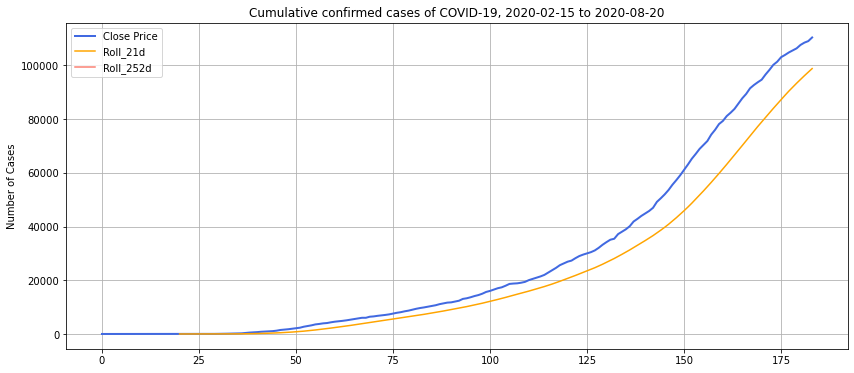

In [77]:
data_1['Cumulative cases'].plot(lw=2., figsize=(14,6), label='Close Price',c='royalblue')
data_1['Cumulative cases'].rolling(21).mean().plot(lw=1.5, label='Roll_21d',c='orange')
data_1['Cumulative cases'].rolling(252).mean().plot(lw=1.5, label='Roll_252d', c='salmon')
plt.title('Cumulative confirmed cases of COVID-19, 2020-02-15 to 2020-08-20')
plt.ylabel('Number of Cases')
plt.grid(); plt.legend()

### 2.1 Imputation of missing value

In [73]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, BayesianRidge, LassoCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

In [82]:
def imputation(data):
    data = data.set_index('Date')
    data = data.apply(pd.to_numeric)
    data = pd.DataFrame(data.replace([np.inf, -np.inf], np.nan))
    data = data.dropna()

def check(data):
    if data.isnull().values.any() == 'False':
        print ("no missing value")
    else:
        print("missing value exist")
        print (data.isnull().sum())
        
    print (np.isinf(data).any())

In [87]:
imputation(data_1)

In [89]:
data_1 = data_1.set_index('Date')

In [91]:
data_1.columns

Index(['Cumulative cases', 'retail', 'grocery_and_pharmacy', 'parks',
       'transit_stations', 'workplaces', 'residential', 'ICU_beds',
       'State FIPS', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS',
       'Number of Trips 1-10', 'Number of Trips 10-100',
       'Number of Trips >100', 'Population Not Staying at Home', '0_9',
       '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_100',
       'prop over 60', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'GovernmentResponseIndex', 'ContainmentHealthIndex',
       'EconomicSupportIndex', 'Annual income', 'covid', 'coronavirus',
       'sanitizer', 'lockdown', 'face mask', 'disinfecting wipes', 'takeout',
       'movie ticket', 'restaurant', 'dining out', 'food delivery', 'flight',
       'train', 'uber', 'stay at home', 'work from home', 'Pandemic',
       'Social Distancing', 'Vaccine', 'Zoom', 'home schooling', 'clorox',
       'quarantine', 'grocery', 'covid test', 'outdoor', 'covid 

In [95]:
features = ['Cumulative cases', 'retail', 'grocery_and_pharmacy', 'parks',
       'transit_stations', 'workplaces', 'residential', 'ICU_beds',
       'State FIPS', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS',
       'Number of Trips 1-10', 'Number of Trips 10-100',
       'Number of Trips >100', 'Population Not Staying at Home', '0_9',
       '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_100',
       'prop over 60', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'GovernmentResponseIndex', 'ContainmentHealthIndex',
       'EconomicSupportIndex', 'Annual income', 'covid', 'coronavirus',
       'sanitizer', 'lockdown', 'face mask', 'disinfecting wipes', 'takeout',
       'movie ticket', 'restaurant', 'dining out', 'food delivery', 'flight',
       'train', 'uber', 'stay at home', 'work from home', 'Pandemic',
       'Social Distancing', 'Vaccine', 'Zoom', 'home schooling', 'clorox',
       'quarantine', 'grocery', 'covid test', 'outdoor', 'covid symptoms']

In [96]:
static_features = ['ICU_beds', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS', '0_9',
                   '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_100',
                   'prop over 60', 'Annual income']
    
static_data_1 = data_1[static_features]

In [97]:
continuous_features = [i for i in features if i not in static_features]
continuous_data_1 = data_1[continuous_features]

In [98]:
data_test = data_1[['Cumulative cases','retail','grocery_and_pharmacy','parks', 'transit_stations', 'workplaces', 'residential','Number of Trips 1-10', 'Number of Trips 10-100',
       'Number of Trips >100', 'Population Not Staying at Home', 'ICU_beds', 'NEVER','prop over 60','covid', 'coronavirus',
       'sanitizer', 'lockdown', 'face mask', 'disinfecting wipes', 'takeout',
       'movie ticket', 'restaurant', 'dining out', 'food delivery', 'flight',
       'train', 'uber', 'stay at home', 'work from home', 'Pandemic',
       'Social Distancing', 'Vaccine', 'Zoom', 'home schooling', 'clorox',
       'quarantine', 'grocery', 'covid test', 'outdoor', 'covid symptoms']]

### 2.2 Bayesian structural time series (BSTS) modeling

/Users/likehang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/likehang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/likehang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    40527.5            4984883.0
Prediction (s.d.)         1074.68 (82.6)     132185.15 (10159.42)
95% CI                    [910.53, 1234.3]   [111994.92, 151819.11]

Absolute effect (s.d.)    39452.83 (82.6)    4852697.85 (10159.42)
95% CI                    [39293.2, 39616.98][4833063.89, 4872888.08]

Relative effect (s.d.)    3671.14% (7.69%)   3671.14% (7.69%)
95% CI                    [3656.28%, 3686.41%][3656.28%, 3686.41%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 40527.5. By contrast, in the absence of an
intervention, we would have expected an average response of 1074.68.
The 95% interval of this counterfactual prediction is [910.53, 12

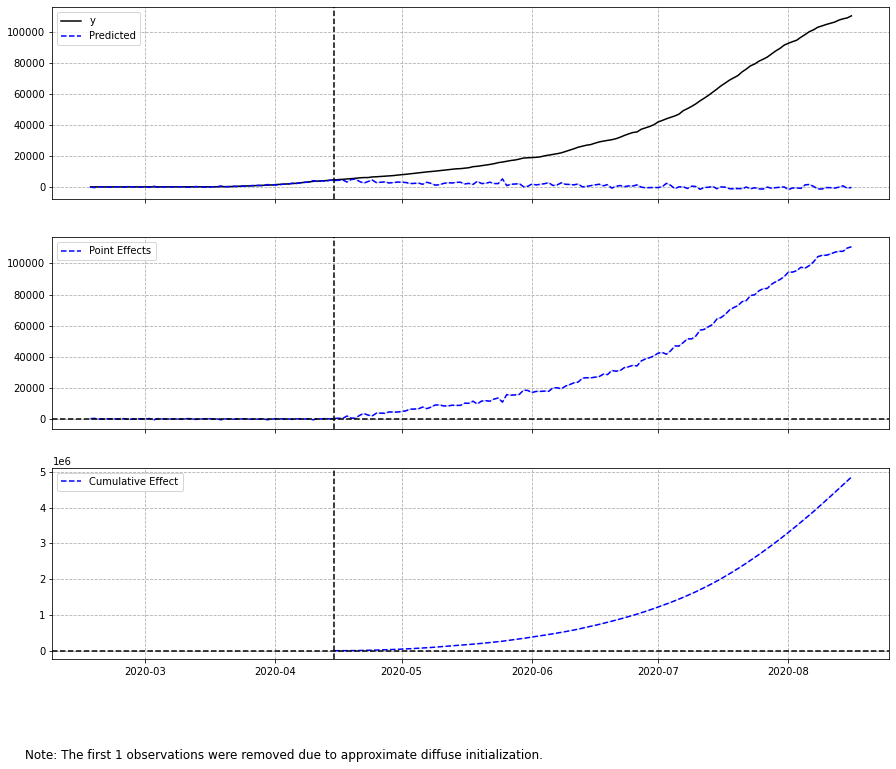

In [128]:
pre_period = ['2020-02-16', '2020-04-15']

post_period = ['2020-04-16', '2020-08-16'] 


ci = CausalImpact(data_test, pre_period, post_period)
print(ci.summary())
print(ci.summary(output='report'))
ci.plot()

In [107]:
ci.trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:       Cumulative cases   No. Observations:                   60
Model:                    local level   Log Likelihood                  25.219
Date:                Mon, 29 Mar 2021   AIC                             33.561
Time:                        23:59:45   BIC                            120.818
Sample:                    02-16-2020   HQIC                            67.623
                         - 04-15-2020                                         
Covariance Type:                  opg                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
sigma2.irregular                        0.0225      0.018      1.265      0.206      -0.012       0.057
sigma2.level                         6.944e-05      0.002      0.033      0.974      -0.004       0.004
beta.retail                            -0.0975      0.674     -0.145      0.885      -1.419       1.224
beta.grocery_and_pharmacy               0.0347      0.270      0.129      0.898      -0.494       0.563
beta.parks                              0.1151      0.164      0.703      0.482      -0.206       0.436
beta.transit_stations                  -0.7254      0.487     -1.490      0.136      -1.679       0.229
beta.workplaces                        -0.6923      0.679     -1.020      0.308      -2.023       0.638
beta.residential                        0.4489      0.773      0.580      0.562      -1.067       1.965
beta.Number of Trips 1-10               0.8677      0.378      2.294      0.022       0.126       1.609
beta.Number of Trips 10-100            -0.8666      0.264     -3.285      0.001      -1.384      -0.350
beta.Number of Trips >100               0.0286      0.189      0.151      0.880      -0.342       0.400
beta.Population Not Staying at Home     0.2905      0.505      0.575      0.565      -0.700       1.281
beta.ICU_beds                        2.122e-08   1.67e-08      1.274      0.203   -1.14e-08    5.39e-08
beta.NEVER                           2.123e-08   1.67e-08      1.274      0.203   -1.14e-08    5.39e-08
beta.prop over 60                    -2.12e-08   1.67e-08     -1.272      0.203   -5.38e-08    1.15e-08
beta.covid                             -0.8184      0.441     -1.856      0.063      -1.683       0.046
beta.coronavirus                        0.0921      0.329      0.280      0.779      -0.552       0.736
beta.sanitizer                         -0.1452      0.211     -0.689      0.491      -0.558       0.268
beta.lockdown                          -0.3444      0.162     -2.121      0.034      -0.663      -0.026
beta.face mask                          0.1253      0.241      0.520      0.603      -0.347       0.597
beta.disinfecting wipes                 0.0464      0.105      0.441      0.659      -0.160       0.252
beta.takeout                           -0.2485      0.108     -2.308      0.021      -0.460      -0.038
beta.movie ticket                       0.0766      0.100      0.766      0.444      -0.119       0.272
beta.restaurant                         0.0607      0.120      0.508      0.611      -0.174       0.295
beta.dining out                         0.0368      0.100      0.369      0.712      -0.158       0.232
beta.food delivery                      0.1006      0.076      1.318      0.188      -0.049       0.250
beta.flight                            -0.0159      0.127     -0.124      0.901      -0.266       0.234
beta.train                             -0.0128      0.097     -0.132      0.895      -0.202       0.176
beta.uber        

In [109]:
ci.summary()

"Posterior Inference {Causal Impact}\n                          Average            Cumulative\nActual                    40527.5            4984883.0\nPrediction (s.d.)         1074.68 (86.38)    132185.15 (10624.38)\n95% CI                    [903.34, 1241.93]  [111111.15, 152757.96]\n\nAbsolute effect (s.d.)    39452.83 (86.38)   4852697.85 (10624.38)\n95% CI                    [39285.57, 39624.16][4832125.04, 4873771.85]\n\nRelative effect (s.d.)    3671.14% (8.04%)   3671.14% (8.04%)\n95% CI                    [3655.57%, 3687.08%][3655.57%, 3687.08%]\n\nPosterior tail-area probability p: 0.0\nPosterior prob. of a causal effect: 100.0%\n\nFor more details run the command: print(impact.summary('report'))"

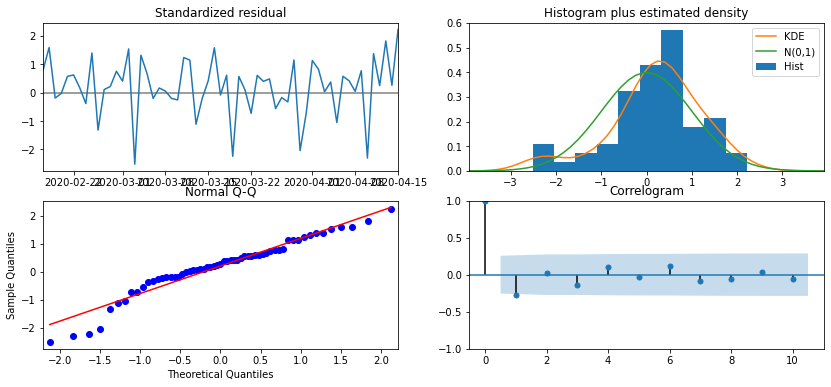

In [108]:
_ = ci.trained_model.plot_diagnostics(figsize=(14,6))

## 3. Experiments for NPI (six traget NPIs in total)

In [362]:
# 1. Generate dataset for experiments
# 2. For each experiment, each state in treatment group, should prepare a dataset
# 3. The dataset structure should be:
     # 3.1 pre-intervention target variable (transmission data: cumulative cases, cumulative death)
     # 3.2 pre-intervention actual value of covariates
     # 3.3 post-intervention predicted value of covariates (synthetic series from the actual post intervention covariates of controls)

### 3.1 Estimate time-varying reproduction number as time series outcome

In [314]:
data_import()

In [315]:
from scipy.stats import gamma, poisson
import epyestim
import epyestim.covid19 as covid19

def estimate_rt():
    xr = iter(range(1,57))
    for i in xr:
        if i not in (3,7,14,43,52):
            file = 'data_%d'%i
            data = data_frames[file]
            data = data.reset_index()
            data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
            data_r = data.set_index('Date')['Cumulative cases']
            
            time_varying_r = covid19.r_covid(data_r,smoothing_window=7,auto_cutoff=False)
            time_varying_r = pd.DataFrame(time_varying_r.reset_index()).rename(columns = {'index':'Date'})

            time_varying_r['Date'] = pd.to_datetime(time_varying_r['Date'])
            rt = time_varying_r[~(time_varying_r['Date'] < '2020-02-15')]
            data = pd.merge(data, rt, on = ['Date'])
            data.drop(columns = ['R_var','Q0.025', 'Q0.5','Q0.975'], inplace = True)
            data_frames[file]=data

In [316]:
estimate_rt()

### 3.2 Experiment for NPI lockdown

#### 3.2.1 Construct the data for analysis

In [320]:
from SyntheticControlMethods import Synth

In [321]:
def getcontrol(control_list):
    
    control_data = pd.DataFrame()
    list = []

    for unit in control_list:
        index = state.index[state['state name'] == unit].item()
        list.append(index)

    for i in list:
        v = state.iloc[i,1]
        c = state.iloc[i,2]
        name = 'data_%d'%c
        data = data_frames[name]
        data = add_google(data, v)
        control_data = control_data.append(data)
        
    return control_data

In [449]:
lst_c_1 = ['Arkansas', 'Connecticut', 'Georgia', 'Louisiana', 'Maine', 'Massachusetts', 'Texas', 'Virginia', 'West Virginia']
lst_t_1 = ['Alabama', 'Colorado', 'Florida', 'Michigan', 'New Jersey', 'New York', 'Pennsylvania', 'South Carolina']

In [341]:
state = pd.read_excel('/Users/likehang/Desktop/state_name_US.xlsx')
control_1 =  getcontrol(lst_c_1)

In [324]:
def generate_syth(state_t, control_data):

    c = state.loc[state['state name'] == state_t, 'FIPS'].iloc[0]
    v = state.loc[state['state name'] == state_t, 'state_ab'].iloc[0]
    name = 'data_%d'%c
    df = data_frames[name]
    df = add_google(df, v)
    df = df.reset_index()
    df = df.append(control_data)
    
    return df

def prepared_data(data):
    df = data
    cols = list(df)
    cols.insert(0, cols.pop(cols.index('State FIPS')))
    df = df.loc[:, cols]
    df = df.drop(columns = "index", axis = 1).reset_index()
    df = df.rename({"index": "date"},axis=1)
    df['date'] = df['date']+1
    df.drop(columns = ['cases','Date','level_0','ConfirmedCases'], axis = 1, inplace = True)
    df["State FIPS"] = df["State FIPS"].astype(str)
    return df

#### 3.2.2 Synthetic control

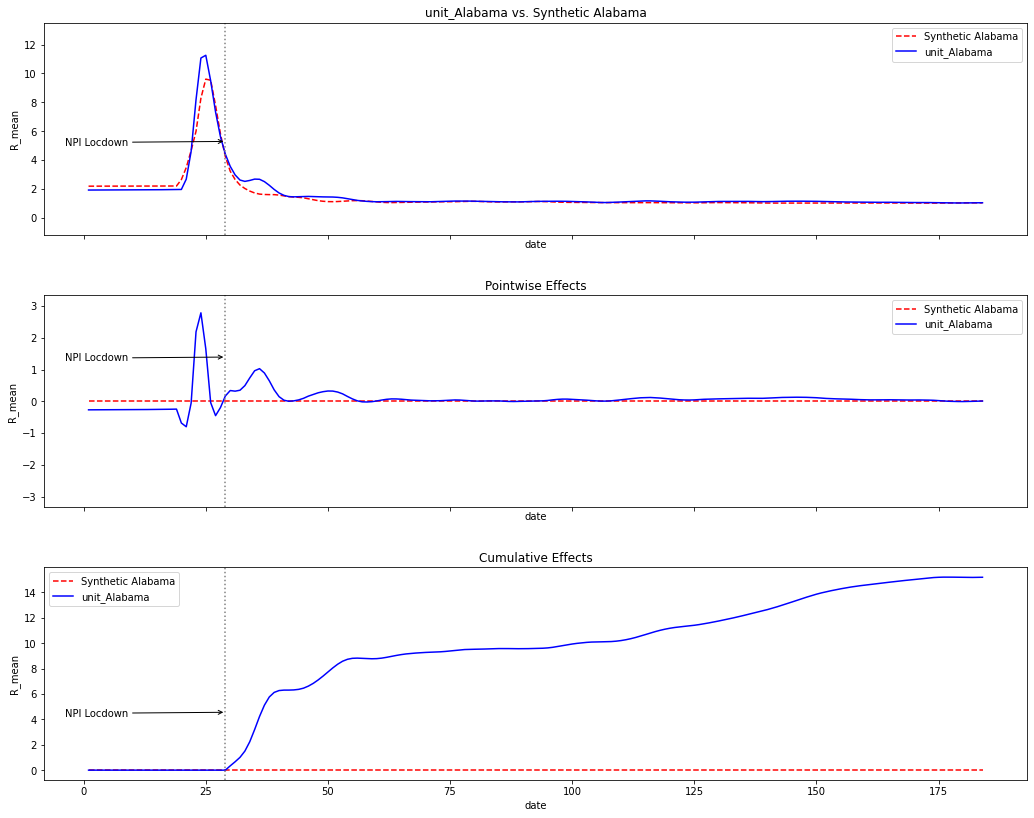

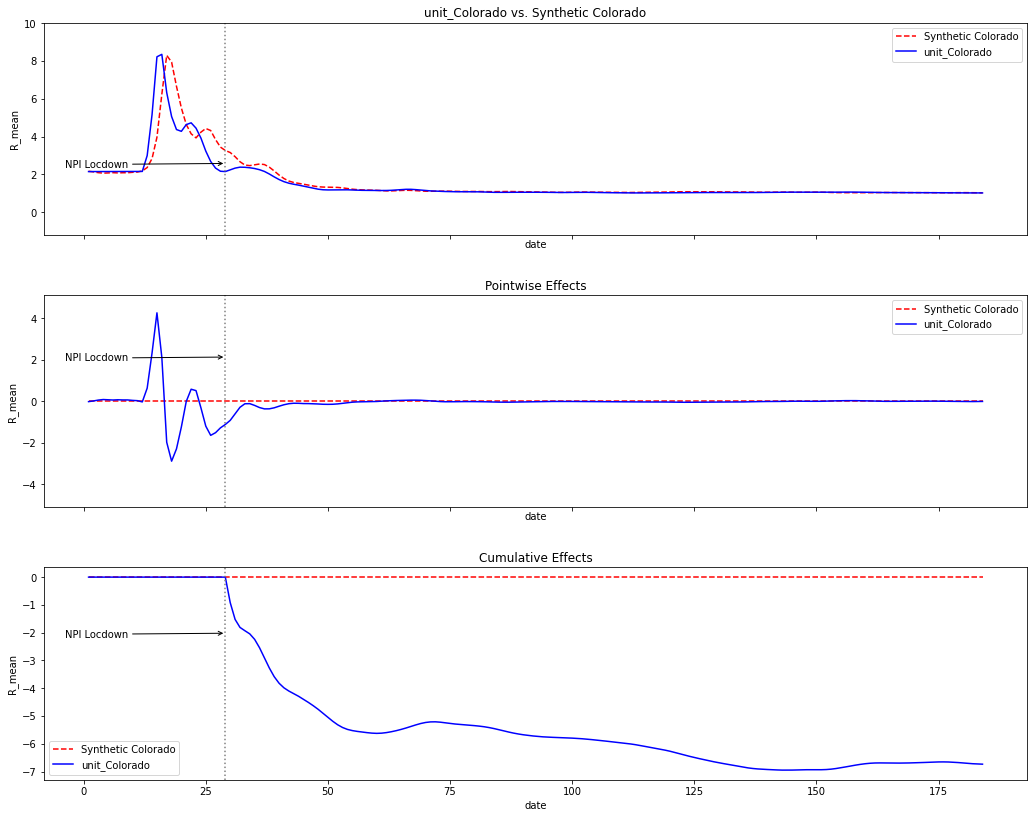

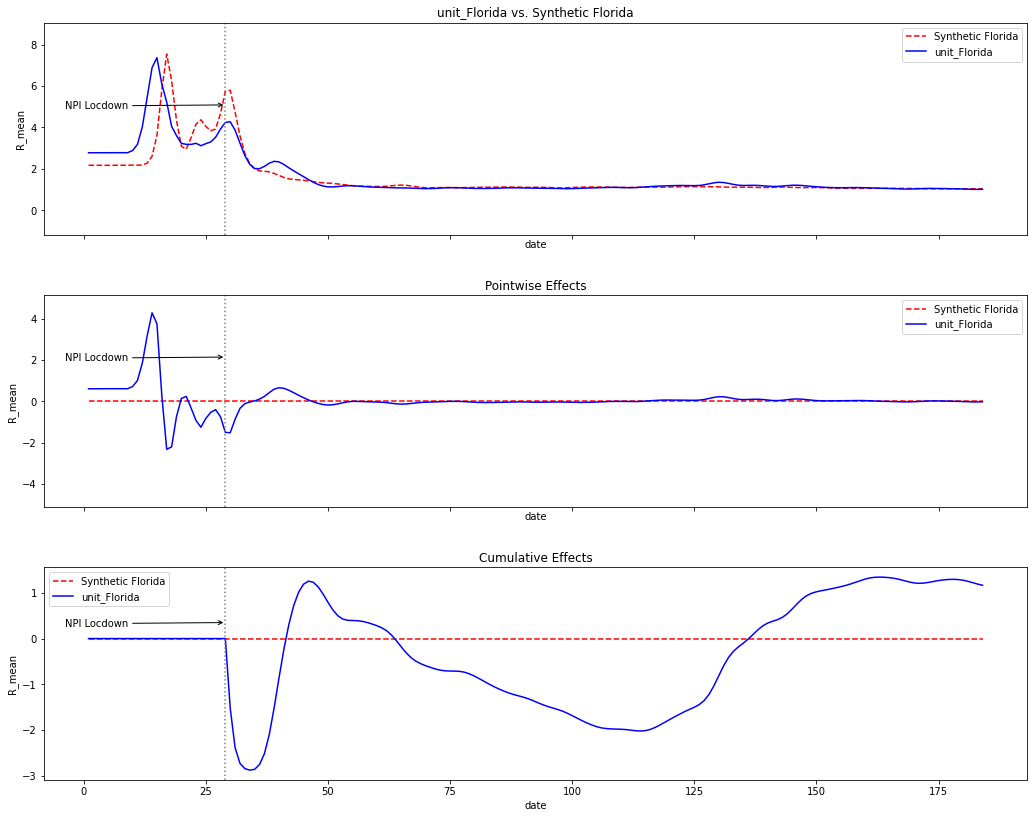

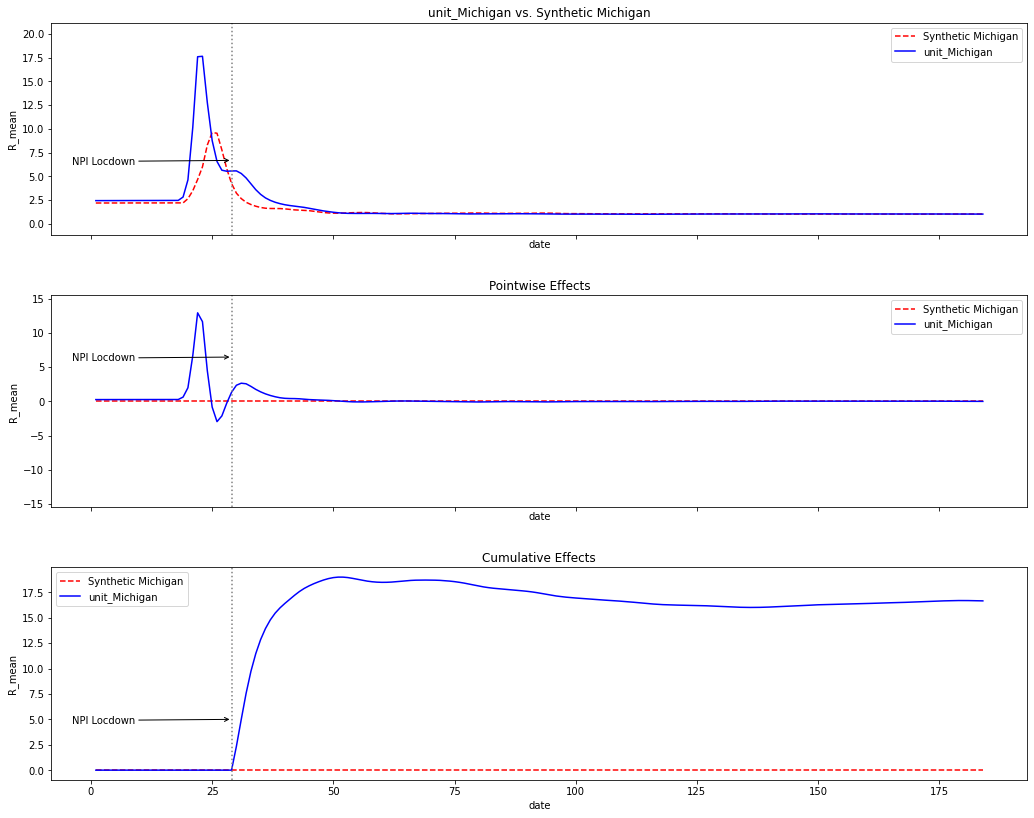

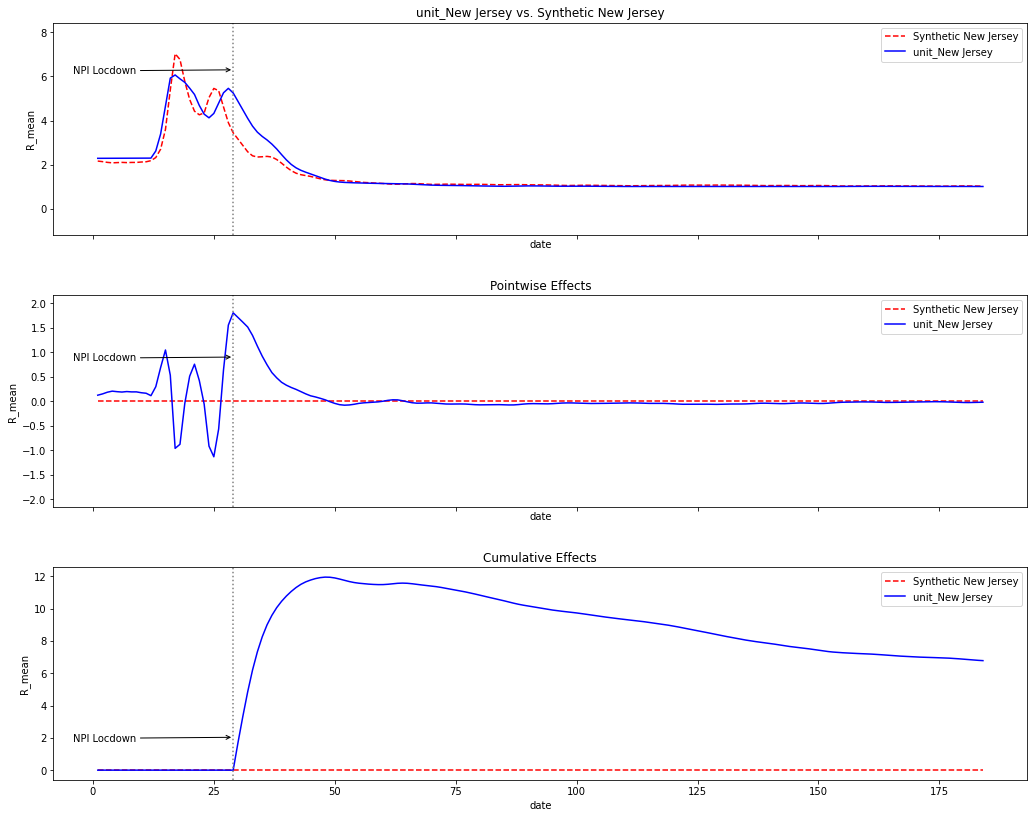

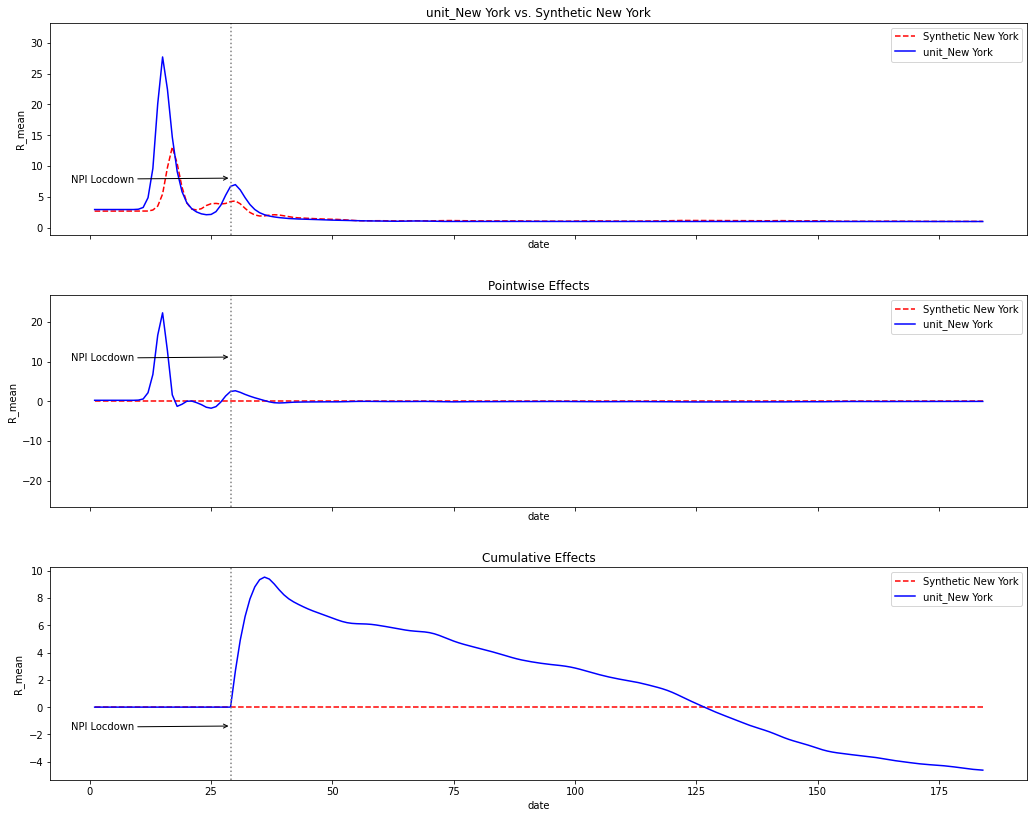

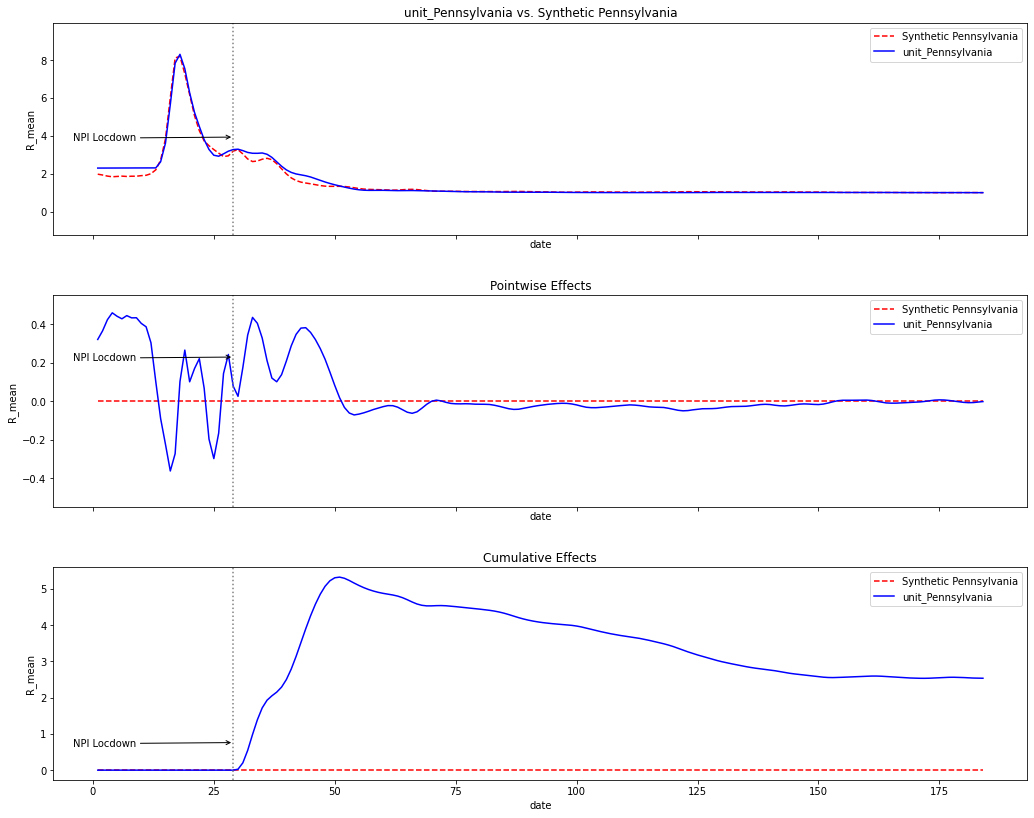

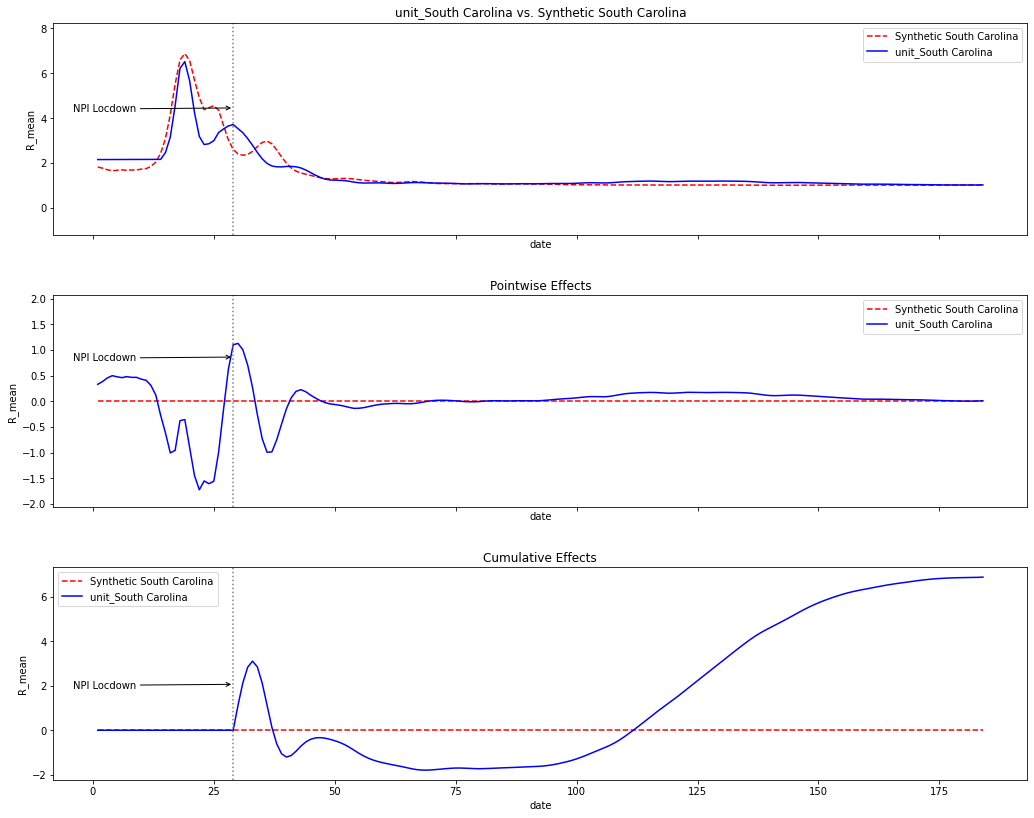

In [450]:
for i in lst_t_1:
    ne = generate_syth(i, control_1)
    df = prepared_data(ne)
    index = state.index[state['state name'] == i].item()
    c = state.iloc[index,2]
    sc = Synth(df, "R_mean", "State FIPS", "date", 30, str(c), pen=0)
    sc.plot(["original", "pointwise", "cumulative"], treated_label="unit_%s" % i, 
            synth_label="Synthetic %s" % i, treatment_label="NPI Locdown")

### 3.3 Experiment for Closures and Regulations of Schools

In [455]:
lst_c_2 = ['Alabama', 'Colorado', 'Florida', 'Michigan', 'New Jersey', 'New York', 'Pennsylvania', 'South Carolina']
lst_t_2 = ['California','Washington']

In [456]:
control_2 =  getcontrol(lst_c_2)

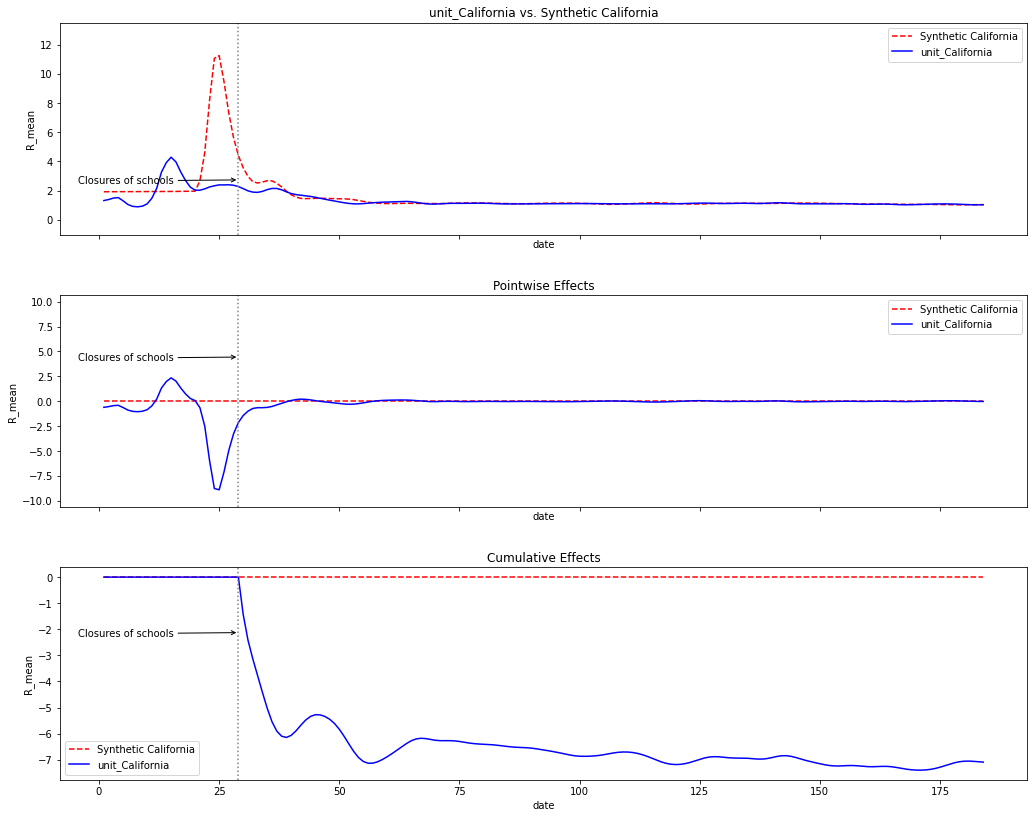

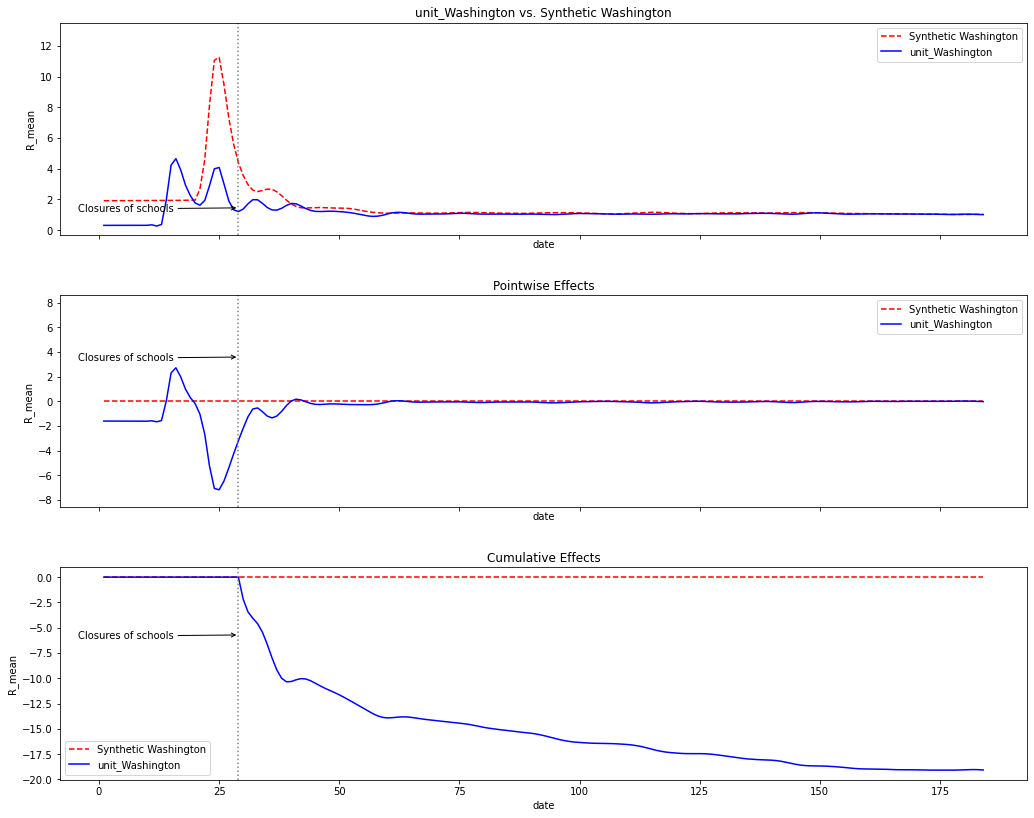

In [459]:
for i in lst_t_2:
    ne = generate_syth(i, control_2)
    df = prepared_data(ne)
    index = state.index[state['state name'] == i].item()
    c = state.iloc[index,2]
    sc = Synth(df, "R_mean", "State FIPS", "date", 30, str(c), pen=0)
    sc.plot(["original", "pointwise", "cumulative"], treated_label="unit_%s" % i, 
            synth_label="Synthetic %s" % i, treatment_label="Closures of schools")

### 3.4 Experiment for Quarantine

In [458]:
lst_c_3 = ['Alabama', 'Colorado', 'Florida', 'Michigan', 'New Jersey', 'New York', 'Pennsylvania', 'South Carolina']
lst_t_3 = ['Maryland']

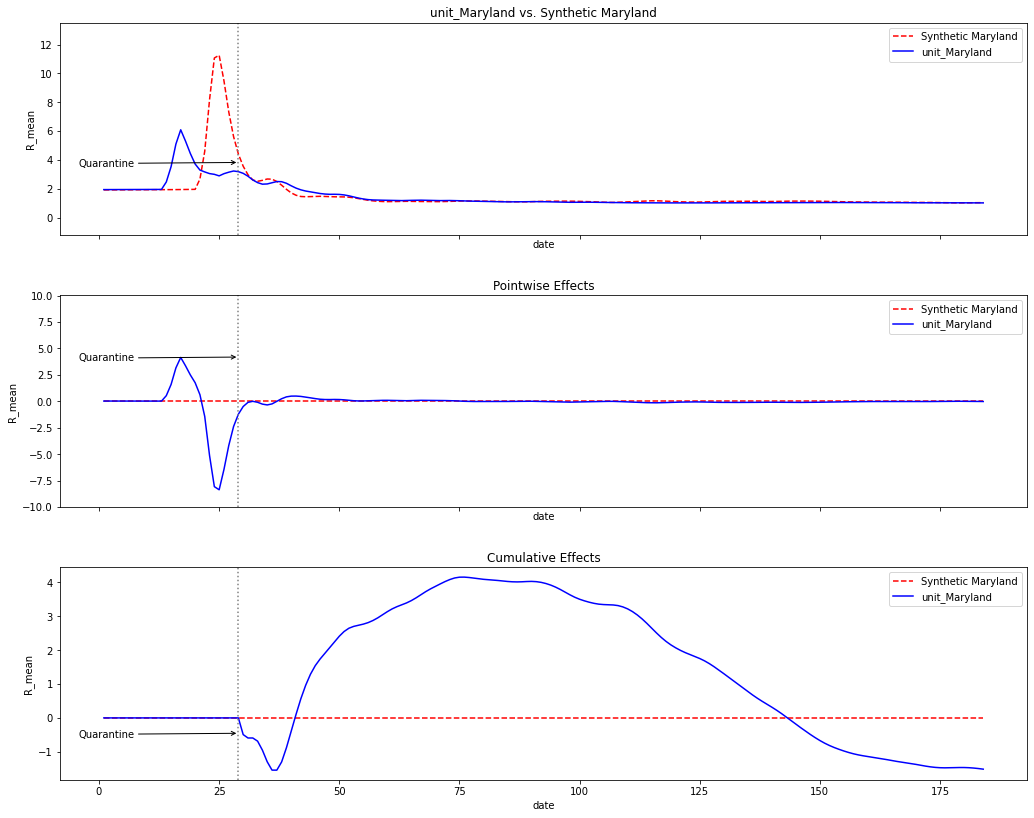

In [460]:
for i in lst_t_3:
    ne = generate_syth(i, control_2)
    df = prepared_data(ne)
    index = state.index[state['state name'] == i].item()
    c = state.iloc[index,2]
    sc = Synth(df, "R_mean", "State FIPS", "date", 30, str(c), pen=0)
    sc.plot(["original", "pointwise", "cumulative"], treated_label="unit_%s" % i, 
            synth_label="Synthetic %s" % i, treatment_label="Quarantine")

### 3.5 Experiment for Restrictions and Regulations of non-essential Businesses

In [461]:
lst_c_4 = ['Minnesota', 'Missouri']
lst_t_4 = ['Maryland']

In [462]:
control_4 =  getcontrol(lst_c_4)

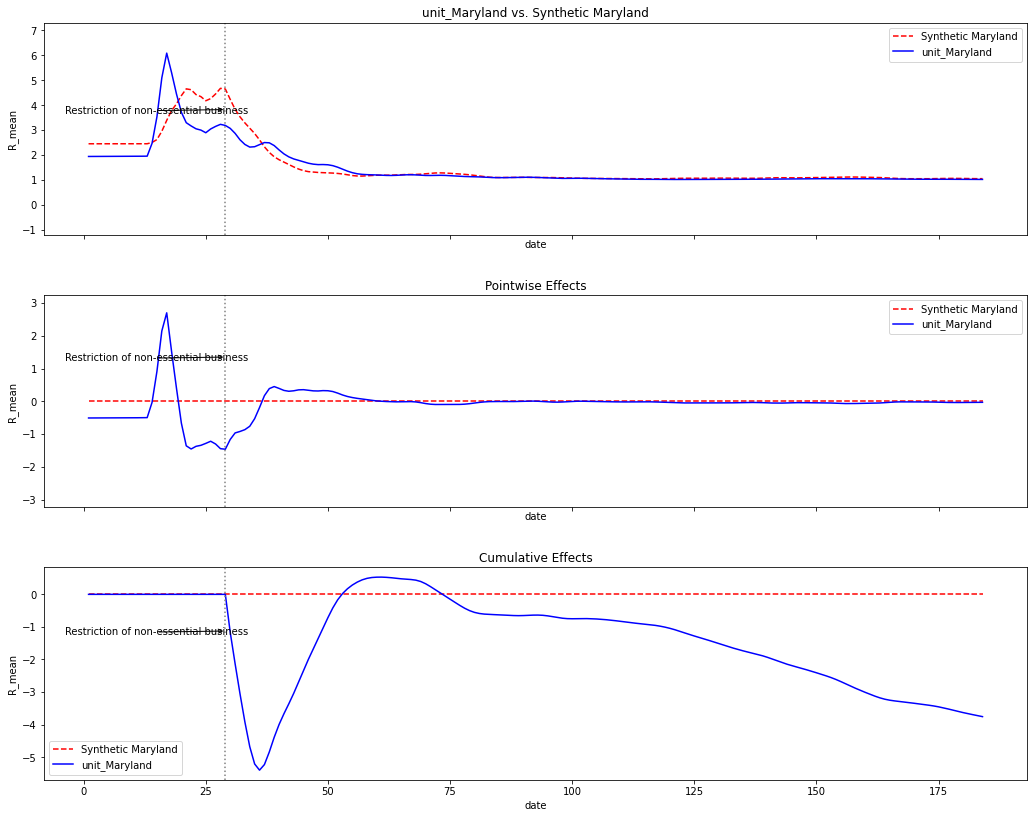

In [463]:
for i in lst_t_4:
    ne = generate_syth(i, control_4)
    df = prepared_data(ne)
    index = state.index[state['state name'] == i].item()
    c = state.iloc[index,2]
    sc = Synth(df, "R_mean", "State FIPS", "date", 30, str(c), pen=0)
    sc.plot(["original", "pointwise", "cumulative"], treated_label="unit_%s" % i, 
            synth_label="Synthetic %s" % i, treatment_label="Restriction of non-essential business")

### 3.6 Experiment for Restrictions of Mass Gatherings 

In [464]:
lst_c_5 = ['California', 'Hawaii', 'Washington']
lst_t_5 = ['Idaho']

In [465]:
control_5 =  getcontrol(lst_c_5)

In [ ]:
for i in lst_t_5:
    ne = generate_syth(i, control_5)
    df = prepared_data(ne)
    index = state.index[state['state name'] == i].item()
    c = state.iloc[index,2]
    sc = Synth(df, "R_mean", "State FIPS", "date", 30, str(c), pen=0)
    sc.plot(["original", "pointwise", "cumulative"], treated_label="unit_%s" % i, 
            synth_label="Synthetic %s" % i, treatment_label="Restriction of mass gatherings")

### 3.7 Experiment for Social Distancing

In [469]:
lst_c_6 = ['Alabama', 'Colorado', 'Florida', 'Michigan', 'New Jersey', 'New York', 'Pennsylvania', 'South Carolina']
lst_t_6 = ['New Mexico']

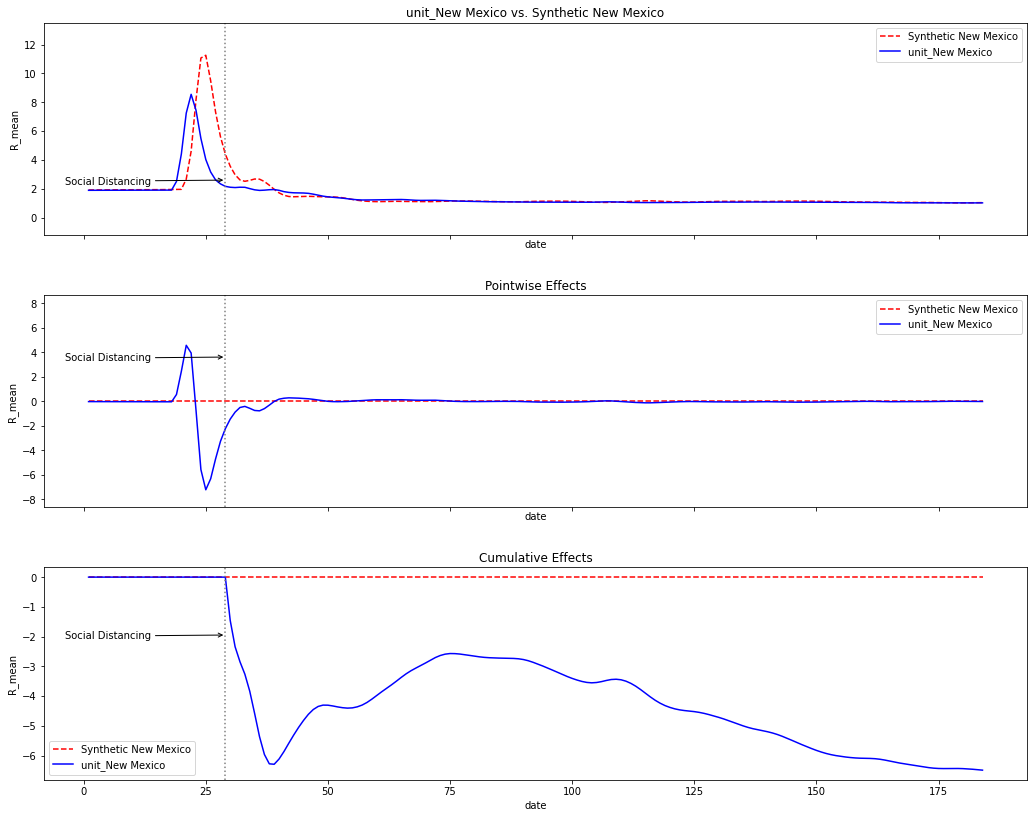

In [470]:
for i in lst_t_6:
    ne = generate_syth(i, control_2)
    df = prepared_data(ne)
    index = state.index[state['state name'] == i].item()
    c = state.iloc[index,2]
    sc = Synth(df, "R_mean", "State FIPS", "date", 30, str(c), pen=0)
    sc.plot(["original", "pointwise", "cumulative"], treated_label="unit_%s" % i, 
            synth_label="Synthetic %s" % i, treatment_label="Social Distancing")

#### 3.2.2 Bayesian variable selection

In [ ]:
from pybats.shared import load_sales_example
from pybats.analysis import *
from pybats.point_forecast import *
from pybats.plot import *

Y = experiment_AL['ConfirmedDeaths'].values
X = experiment_AL[['Cumulative cases','retail','grocery_and_pharmacy','parks', 'transit_stations', 'workplaces', 'residential','Number of Trips 1-10', 'Number of Trips 10-100',
       'Number of Trips >100', 'Population Not Staying at Home', 'ICU_beds', 'NEVER','prop over 60','covid', 'coronavirus',
       'sanitizer', 'lockdown', 'face mask', 'disinfecting wipes', 'takeout',
       'movie ticket', 'restaurant', 'dining out', 'food delivery', 'flight',
       'train', 'uber', 'stay at home', 'work from home', 'Pandemic',
       'Social Distancing', 'Vaccine', 'Zoom', 'home schooling', 'clorox',
       'quarantine', 'grocery', 'covid test', 'outdoor', 'covid symptoms']].values

prior_length = 30   # Number of days of data used to set prior
k = 1               # Forecast horizon
rho = 0.5           # Random effect discount factor to increase variance of forecast distribution
forecast_start = pd.to_datetime('2020-08-01') # Date to start forecasting
forecast_end = pd.to_datetime('2018-08-20') 


In [377]:
data = data_frames['data_1']
data_AL = add_google(data, 'US-AL')

In [375]:
data = data_frames['data_1']

In [378]:
data_AL.columns

Index(['index', 'Date', 'Cumulative cases', 'retail', 'grocery_and_pharmacy',
       'parks', 'transit_stations', 'workplaces', 'residential', 'ICU_beds',
       'State FIPS', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS',
       'Number of Trips 1-10', 'Number of Trips 10-100',
       'Number of Trips >100', 'Population Not Staying at Home', '0_9',
       '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_100',
       'prop over 60', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'GovernmentResponseIndex', 'ContainmentHealthIndex',
       'EconomicSupportIndex', 'Annual income', 'cases', 'R_mean', 'covid',
       'coronavirus', 'sanitizer', 'lockdown', 'face mask',
       'disinfecting wipes', 'takeout', 'movie ticket', 'restaurant',
       'dining out', 'food delivery', 'flight', 'train', 'uber',
       'stay at home', 'work from home', 'Pandemic', 'Social Distancing',
       'Vaccine', 'Zoom', 'home schooling', 'clorox', 'quarantine', 'grocer

In [454]:
data_AL.to_csv("/Users/likehang/Desktop/data_AL.csv")

In [410]:
import BayesianLasso as bl

X = data_AL[['retail','grocery_and_pharmacy','parks', 'transit_stations', 'workplaces', 'residential','Number of Trips 1-10', 'Number of Trips 10-100',
       'Number of Trips >100', 'Population Not Staying at Home', 'ICU_beds', 'NEVER','prop over 60','covid', 'coronavirus',
       'sanitizer', 'lockdown', 'face mask', 'disinfecting wipes', 'takeout',
       'movie ticket', 'restaurant', 'dining out', 'food delivery', 'flight',
       'train', 'uber', 'stay at home', 'work from home', 'Pandemic',
       'Social Distancing', 'Vaccine', 'Zoom', 'home schooling', 'clorox',
       'quarantine', 'grocery', 'covid test', 'outdoor', 'covid symptoms']].values

y = data_AL.R_mean

lasso = bl.BayesianLassoRegression()
lasso.fit(X, y)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 207 seconds.
There were 883 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.44120168964090795, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8909340945740484, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 926 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.19812915306113774, but should be close to 0.8. Try to increase the number of tuning steps.
There were 956 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.540571475199

BayesianLassoRegression()